In [1]:
import numpy as np
import pandas as pd
import os, re, math, platform
from pathlib import Path
import matplotlib.pyplot as plt
import json
import joblib
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score
from imblearn.metrics import geometric_mean_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis as PA
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from matplotlib import pyplot
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve, roc_curve, auc, fbeta_score,roc_auc_score
from fea_extract import read_fasta,insert_AAC,insert_DPC,insert_CKSAAGP,insert_CTD,insert_PAAC,insert_AAI,insert_GTPC,insert_QSO,insert_AAE,insert_PSAAC,insert_word2int,insert_ASDC
import warnings 
from collections import Counter
from tools import cv,evaluate, pro_data
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
warnings.filterwarnings('ignore')
seed=10

In [22]:
X_test_norm = pd.read_csv('data/test/X_test_norm.csv').to_numpy()
y_test_norm = pd.read_csv('data/test/y_test.csv').to_numpy()
X_v = pd.read_csv('data/test/X_v.csv').to_numpy()
y_v = pd.read_csv('data/test/y_v.csv').to_numpy()
X_train_resampled = pd.read_csv('data/train/X_train_resampled.csv').to_numpy()
y_train_resampled = pd.read_csv('data/train/y_train_resampled.csv').to_numpy()

In [3]:
X = pd.read_csv('data/train/Seq_X_train_all.csv')
feature_names = X.columns[2:]

In [23]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [24]:
def udf_MI(X, y):
    result = mutual_info_classif(X, y, n_neighbors = 5) # 用户可以输入想要的临近数
    return result

In [25]:
np.random.seed(1234)
idx = np.random.permutation(len(X_train_resampled))
X_norm_train = X_train_resampled[idx]
y_norm_train = y_train_resampled[idx]

In [26]:
score = udf_MI(X_norm_train,y_norm_train)

In [27]:
score

array([0.1264537 , 0.13144588, 0.2189469 , ..., 0.12052441, 0.01546697,
       0.10393284])

In [28]:
selector_MI = SelectKBest(udf_MI, k=415)
selector_MI.fit(X_norm_train,y_norm_train)

SelectKBest(k=415, score_func=<function udf_MI at 0x00000136DCE95820>)

In [29]:
MI_transformed_test = selector_MI.transform(X_test_norm)

MI_transformed_train = selector_MI.transform(X_train_resampled) # 转换训练集

In [11]:
X_A = pd.read_csv('data/train/X_train_resampled_all.csv').to_numpy()

In [12]:
MI_transformed_train = selector_MI.transform(X_A)

In [13]:
X_MI_train = pd.DataFrame(MI_transformed_train)
X_MI_train.to_csv('Feature_different/X_train_MI_A.csv',index = False)

In [30]:
X_MI_train = pd.DataFrame(MI_transformed_train)
X_MI_train.to_csv('Feature_different/X_train_MI.csv',index = False)
X_MI_test = pd.DataFrame(MI_transformed_test)
X_MI_test.to_csv('Feature_different/X_test_MI.csv',index = False)

In [10]:
num_index = []
for i in range(1296):
    num_index.append(str(i))
    
num_index = np.array(num_index)

In [11]:
# result = [(x,y) for x,y in zip(feature_names[:],score)]
result = [(x,y) for x,y in zip(num_index[:],score)]
result = sorted(result, key=lambda x: x[1], reverse=True)

In [12]:
MI_fs = [x[0] for x in result]

In [13]:
def MI_ALL(X_train,y_train,X_v,y_v):
    clf = ExtraTreesClassifier()
    kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
    avg_score_valid=[]
    scores_test = []
    X = X_train
    Y = y_train
    for train_index, test_index in kf.split(X,Y):
        kf_X_train,kf_X_test=X[train_index],X[test_index]
        kf_y_train,kf_y_test=Y[train_index],Y[test_index]
        clf.fit(kf_X_train,kf_y_train)
        scores_test.append(clf.score(X_v,y_v))
    scores = np.array(scores_test)
    avg_score_test = np.sum(scores)/10
    print("This is validation score: %s" % (avg_score_test))
    return avg_score_test

In [14]:
X_=pd.read_csv('data/process_X.csv')

In [16]:
S = []
num = []
X_Test = pd.DataFrame(X_v,columns=num_index)
for i in range(5,600,5):
    y_train = X_['label'].to_numpy()
    x_train = X_[MI_fs[:i]]
    x_test = X_Test[MI_fs[:i]]
    X_test1 = np.array(x_test)
    X_train1 = np.array(x_train)
    print(X_train1.shape)
    avg_score_test = MI_ALL(X_train1,y_train,X_test1,y_v)
    S.append(avg_score_test)
    num.append(i)

(2009, 5)
This is validation score: 0.8798833819241982
(2009, 10)
This is validation score: 0.8865889212827988
(2009, 15)
This is validation score: 0.8991253644314868
(2009, 20)
This is validation score: 0.8865889212827988
(2009, 25)
This is validation score: 0.885131195335277
(2009, 30)
This is validation score: 0.8860058309037901
(2009, 35)
This is validation score: 0.8839650145772595
(2009, 40)
This is validation score: 0.89533527696793
(2009, 45)
This is validation score: 0.8985422740524781
(2009, 50)
This is validation score: 0.89533527696793
(2009, 55)
This is validation score: 0.9040816326530612
(2009, 60)
This is validation score: 0.8976676384839651
(2009, 65)
This is validation score: 0.8973760932944608
(2009, 70)
This is validation score: 0.8997084548104957
(2009, 75)
This is validation score: 0.9049562682215744
(2009, 80)
This is validation score: 0.9043731778425658
(2009, 85)
This is validation score: 0.903206997084548
(2009, 90)
This is validation score: 0.9134110787172013

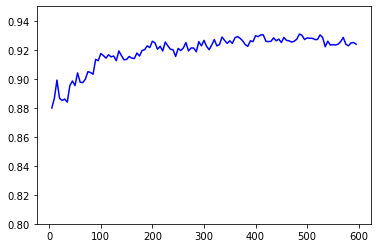

In [19]:
plt.plot(num,S,'b')
plt.ylim(0.8,0.95)
# plt.yticks([0.985,0.990,0.995,1.00])
# plt.xlim(200,1290)
plt.show()

In [20]:
S_mrmd = pd.DataFrame(S)
S_mrmd.to_csv('data/S_MI.csv',index = False)
NUM = pd.DataFrame(num)
NUM.to_csv('data/NUM_MI.csv',index = False)

In [21]:
S_MI = pd.read_csv('data/S_MI.csv').to_numpy()
S_MRMD = pd.read_csv('data/S_MRMD.csv').to_numpy()

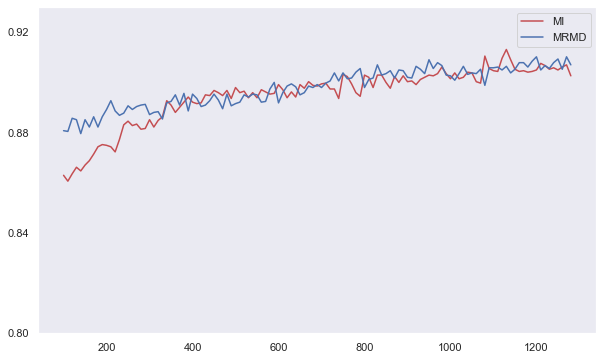

In [57]:
plt.figure(figsize=(10,6))
plt.grid(False)
plt.plot(num,S_MI,'r',label='MI')
plt.plot(num,S_MRMD,'b',label = 'MRMD')
plt.ylim(0.8,0.93)
plt.yticks([0.80,0.84,0.88,0.92])
# plt.xlim(200,1290)
plt.legend(loc='best')
plt.show()

In [21]:
S_MI = pd.DataFrame(S_MI)

In [22]:
NUM = pd.read_csv('data/NUM_MI.csv')

In [23]:
MI = pd.concat([NUM,S_MI],axis = 1)
MI.to_csv('data/MI.csv',index = False)

In [24]:
S_MRMD = pd.read_csv('data/S_MRMD.csv')

In [25]:
MRMD = pd.concat([NUM,S_MRMD],axis = 1)
MRMD.to_csv('data/MRMD.csv',index = False)

In [12]:
PAAC=23
AAC=20
CKSAAGP=75
CTD=147
DPC=400
GTPC=125
QSO=46
AAE=60
ASDC=400

In [13]:
PAAC_N=0
AAC_N=0
CKSAAGP_N=0
CTD_N=0
DPC_N=0
GTPC_N=0
QSO_N=0
AAE_N=0
ASDC_N=0

In [14]:
NUM=[]
NUM1=[]
for i in MI_fs[:1120]:
    if 0<= int(i) <23:
        PAAC_N += 1
    elif 23<= int(i) <43:
        AAC_N += 1
    elif 43<= int(i) <118:
        CKSAAGP_N += 1
    elif 118<= int(i) <265:
        CTD_N += 1
    elif 265<= int(i) <665:
        DPC_N += 1
    elif 665<= int(i) <790:
        GTPC_N += 1
    elif 790<= int(i) <836:
        QSO_N += 1
    elif 836<= int(i) <896:
        AAE_N += 1
    elif 896<= int(i) <1296:
        ASDC_N += 1
NUM.append(PAAC_N/23)
NUM.append(AAC_N/20)
NUM.append(CKSAAGP_N/75)
NUM.append(CTD_N/147)
NUM.append(DPC_N/400)
NUM.append(GTPC_N/125)
NUM.append(QSO_N/46)
NUM.append(AAE_N/60)
NUM.append(ASDC_N/400)
NUM1.append(PAAC_N)
NUM1.append(AAC_N)
NUM1.append(CKSAAGP_N)
NUM1.append(CTD_N)
NUM1.append(DPC_N)
NUM1.append(GTPC_N)
NUM1.append(QSO_N)
NUM1.append(AAE_N)
NUM1.append(ASDC_N)

In [24]:
NUM

[1.0, 1.0, 1.0, 1.0, 0.675, 0.824, 1.0, 0.7666666666666667, 0.975]

In [27]:
names = ['PAAC','AAC','CKSAAGP','CTD','DPC','GTPC','QSO','AAE','ASDC']
NUm = np.array(NUM)*(1120/1296)

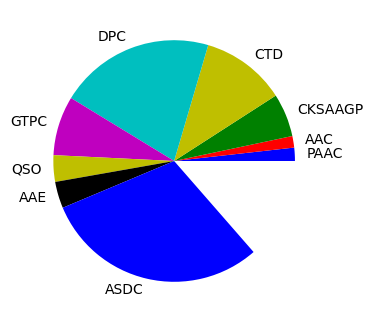

In [16]:
plt.figure(figsize=(10, 4), dpi=100)

# 3）绘制饼图
plt.pie(NUm, labels=names,colors=['b','r','g','y','c','m','y','k'])

# # 显示图例
# plt.legend(loc='best')

# # 添加标题
# plt.title("o1PO )oineH. 93viuo.uod")

# 4）显示图像
plt.show()

(0.0, 1.0)

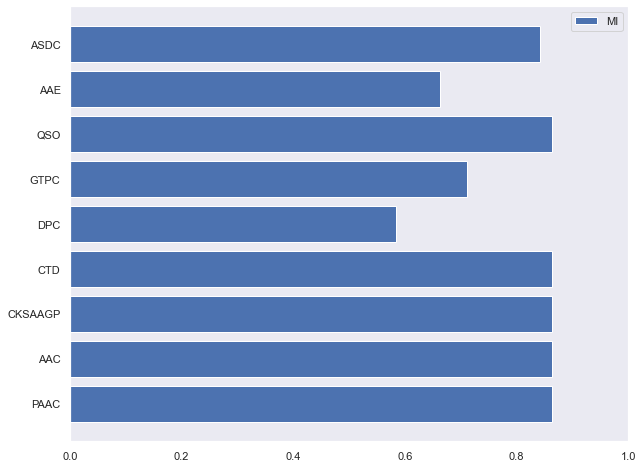

In [32]:
sns.set()
plt.figure(figsize=(10,8))
plt.grid(False)
plt.barh(names,NUm,label='MI',color = "b")
plt.legend(loc='upper right')
plt.xlim(0.0,1.0)

In [33]:
num_d = np.zeros([1296,1])
for i in MI_fs[:1120]:
    num_d[int(i)]=1

In [34]:
num_D = pd.DataFrame(num_d)
num_D.to_csv('MI.csv',index=False)

In [35]:
MI = pd.DataFrame(MI_fs)
MI.to_csv('data/MI.csv',index=False)